# Accounts Receivable

###### Understand the factors of successful collection efforts. You can Predict which customers will pay fastest and recover more money and improve collections efficiency.

In [84]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

# 1 Get the Data

In [85]:
df = pd.read_csv('07 WA_Fn-UseC_-Accounts-Receivable.csv')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 2465
Data columns (total 12 columns):
countryCode      2466 non-null int64
customerID       2466 non-null object
PaperlessDate    2466 non-null object
invoiceNumber    2466 non-null int64
InvoiceDate      2466 non-null object
DueDate          2466 non-null object
InvoiceAmount    2466 non-null float64
Disputed         2466 non-null object
SettledDate      2466 non-null object
PaperlessBill    2466 non-null object
DaysToSettle     2466 non-null int64
DaysLate         2466 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 250.5+ KB


In [86]:
df1 = df[df['DaysLate']>0].copy()
df2 = pd.DataFrame(df1.groupby(['customerID'], axis=0, as_index=False)['DaysLate'].count())
df2.columns = (['customerID','repeatCust'])
df3 = pd.merge(df, df2, how='left', on='customerID')
df3['repeatCust'].fillna(0, inplace=True)

In [87]:
df = df3
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 2465
Data columns (total 13 columns):
countryCode      2466 non-null int64
customerID       2466 non-null object
PaperlessDate    2466 non-null object
invoiceNumber    2466 non-null int64
InvoiceDate      2466 non-null object
DueDate          2466 non-null object
InvoiceAmount    2466 non-null float64
Disputed         2466 non-null object
SettledDate      2466 non-null object
PaperlessBill    2466 non-null object
DaysToSettle     2466 non-null int64
DaysLate         2466 non-null int64
repeatCust       2466 non-null float64
dtypes: float64(2), int64(4), object(7)
memory usage: 269.7+ KB


In [88]:
def func_CC (x):
    if x==391: return "a. 391"
    elif x==818: return "c. 818"
    else: return "b. others"
df['countryCode_bin'] = df['countryCode'].apply(func_CC)

In [89]:
def func_RC (x):
    if x<2: return "a. less than 2"
    elif x<6: return "b. less than 6"
    elif x<15: return "c. less than 15"
    else: return "d. more than 15"
df['repeatCust_bin'] = df['repeatCust'].apply(func_RC)

In [90]:
def func_IA (x):
    if x>70: return "b. more than 70"
    else: return "a. less than 70"
df['InvoiceAmount_bin'] = df['InvoiceAmount'].apply(func_IA)

In [91]:
df = df[['Disputed','PaperlessBill','DaysLate','countryCode_bin','repeatCust_bin','InvoiceAmount_bin']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 2465
Data columns (total 6 columns):
Disputed             2466 non-null object
PaperlessBill        2466 non-null object
DaysLate             2466 non-null int64
countryCode_bin      2466 non-null object
repeatCust_bin       2466 non-null object
InvoiceAmount_bin    2466 non-null object
dtypes: int64(1), object(5)
memory usage: 134.9+ KB


# 2a Disputed

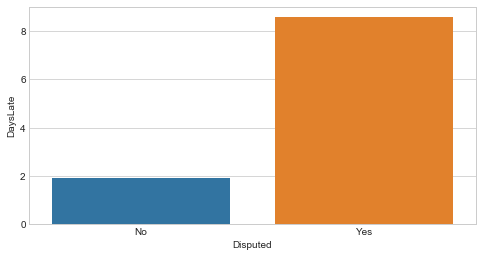

In [92]:
temp = pd.DataFrame(df.groupby(['Disputed'], axis=0, as_index=False)['DaysLate'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Disputed", y="DaysLate",data=temp)

# 2b PaperlessBill

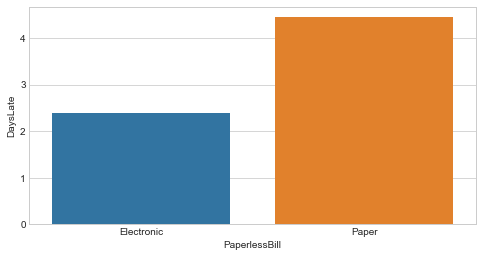

In [93]:
temp = pd.DataFrame(df.groupby(['PaperlessBill'], axis=0, as_index=False)['DaysLate'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="PaperlessBill", y="DaysLate",data=temp)

# 2c countryCode_bin

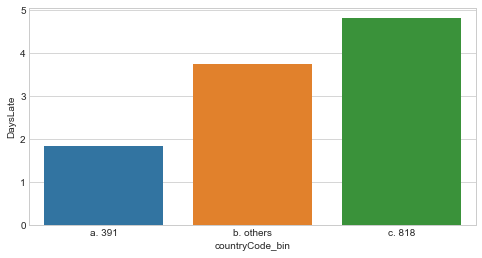

In [94]:
temp = pd.DataFrame(df.groupby(['countryCode_bin'], axis=0, as_index=False)['DaysLate'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="countryCode_bin", y="DaysLate",data=temp)

# 2d repeatCust_bin

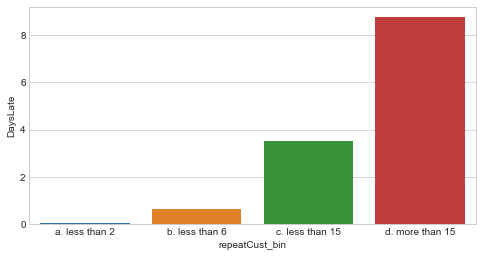

In [95]:
temp = pd.DataFrame(df.groupby(['repeatCust_bin'], axis=0, as_index=False)['DaysLate'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="repeatCust_bin", y="DaysLate",data=temp)

# 2e InvoiceAmount_bin

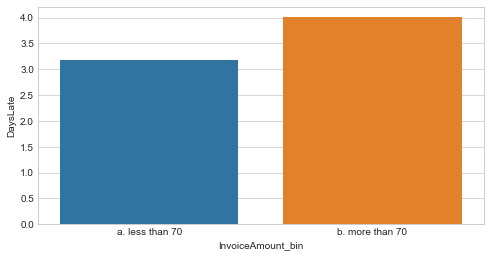

In [96]:
temp = pd.DataFrame(df.groupby(['InvoiceAmount_bin'], axis=0, as_index=False)['DaysLate'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="InvoiceAmount_bin", y="DaysLate",data=temp)

# 3 Train Test Split

In [97]:
df.drop('countryCode_bin',axis=1,inplace=True)

In [98]:
cat_feats = ['Disputed','PaperlessBill','repeatCust_bin','InvoiceAmount_bin']
final_data = pd.get_dummies(df,columns=cat_feats,drop_first=True)

In [99]:
x = final_data.drop(['DaysLate'],axis=1)
y = final_data['DaysLate']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=101)

# 4 Building the Model

In [100]:
x_train = sm.add_constant(x_train).copy()
lm_sm = sm.OLS(y_train, x_train)
est = lm_sm.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               DaysLate   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     237.1
Date:                Sat, 18 Nov 2017   Prob (F-statistic):          5.90e-221
Time:                        00:32:03   Log-Likelihood:                -5130.1
No. Observations:                1726   AIC:                         1.027e+04
Df Residuals:                    1719   BIC:                         1.031e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

# 5 Predictions and Evaluation

In [101]:
x_test = sm.add_constant(x_test).copy()
y_pred = est.predict(x_test)

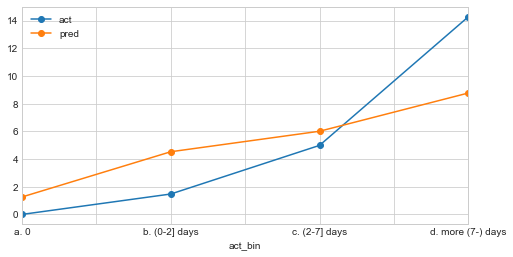

In [102]:
y = pd.concat([y_test,pd.DataFrame(y_pred)],axis=1)
y.columns = ('act','pred')

def act_decile (x):
    if x == 0: return "a. 0"
    elif x <= 2: return "b. (0-2] days"
    elif x <= 7: return "c. (2-7] days"
    else: return "d. more (7-) days"
y['act_bin'] = y['act'].apply(act_decile)

temp = pd.DataFrame(y.groupby(['act_bin'], axis=0, as_index=False)['act','pred'].mean())
temp.index = temp['act_bin']
temp.plot(marker='o',figsize=(8,4))